# Machine Learning for metabolomes of microbial communities

In [1]:
# imports
import sys
sys.path.append( '../FIA' )
sys.path.append( '../ML' )
sys.path.append( '..' )

from helpers.normalization import *
from FIA import *
from ML4com import *
from DL4com import *

## Loading in

In [2]:
orig_dir = os.path.normpath(os.path.join(os.getcwd(), "/mnt/d/data/Com8_grown_together"))
data_dir  = os.path.normpath(os.path.join(os.getcwd(), "/mnt/d/runs/FIA/Com8_grown_together"))
run_dir = os.path.normpath(os.path.join(os.getcwd(), "/mnt/d/runs/ML/annot"))

strains = pd.read_csv( os.path.join(orig_dir, "strains.tsv"), sep="\t")
comm = pd.read_csv( os.path.join(orig_dir, "comb_one_hot.tsv"), sep="\t")
metData = pd.read_csv( os.path.join(orig_dir, "metData.tsv"), sep="\t")
metData.index = pd.read_csv( os.path.join(orig_dir, "metName.tsv"), sep="\t")

met_raw_pos = pd.read_excel( os.path.join(orig_dir,"FIA-Data Com8_20230717_P0024_msAV206-312.xlsx"), sheet_name="pos" )
met_raw_neg = pd.read_excel( os.path.join(orig_dir,"FIA-Data Com8_20230717_P0024_msAV206-312.xlsx"), sheet_name="neg" )
met_raw_comb = pd.concat( [total_ion_count_normalization( join_df_metNames(met_raw_pos) ),
                           total_ion_count_normalization( join_df_metNames(met_raw_neg) )] )

outdir = Path( os.path.normpath( run_dir ) )

## Normalization

In [3]:
X = met_raw_comb.transpose()
ys = comm
targets = strains.values.flatten()

## Learning and tuning

In [4]:
from sklearn.model_selection import cross_val_score

In [5]:
run_dir = "../../runs/ML/annot"

In [6]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

### SVM

In [ ]:
from sklearn.tree import DecisionTreeClassifier

configuration_space = ConfigurationSpace()
ccp_alpha   = Float("ccp_alpha", (1e-3, 1e-1), log=True, default=0.01)
configuration_space.add_hyperparameters([ccp_alpha])

classifier = SKL_Classifier(X, ys, cv=5, configuration_space=configuration_space, classifier=DecisionTreeClassifier)

scenario = Scenario(classifier.configuration_space, deterministic=True, n_workers=4, n_trials=200,
                    walltime_limit=np.inf, cputime_limit=np.inf, trial_memory_limit=None,
                    output_directory=Path(os.path.normpath("/mnt/d/runs/ML/NN/smac_dt")))

smac = HyperparameterOptimizationFacade(scenario, classifier.train)
incumbent = smac.optimize()

In [ ]:
if isinstance(incumbent, list):
    best_hp = incumbent[0]
else: 
    best_hp = incumbent

metrics_df = cross_validate_model_sklearn(DecisionTreeClassifier, X, ys, strains["0"], config=best_hp,
								          fold=StratifiedKFold(n_splits=5), verbosity=0)

### Decision Tree

In [42]:
algorithm = "decision_tree"
from sklearn.tree import DecisionTreeClassifier

configuration_space = ConfigurationSpace()
ccp_alpha   = Float("ccp_alpha", (1e-3, 1e-1), log=True, default=0.01)
configuration_space.add_hyperparameters([ccp_alpha])

classifier = SKL_Classifier(X, ys, cv=5, configuration_space=configuration_space, classifier=DecisionTreeClassifier)

scenario = Scenario(classifier.configuration_space, deterministic=True, n_workers=4, n_trials=200,
                    walltime_limit=np.inf, cputime_limit=np.inf, trial_memory_limit=None,
                    output_directory=Path(os.path.normpath( os.path.join(run_dir, algorithm))))

smac = HyperparameterOptimizationFacade(scenario, classifier.train)

mlflow.set_tracking_uri(Path(os.path.join(outdir, "mlruns")))
mlflow.set_experiment(f"annotated_{algorithm}")
with mlflow.start_run(run_name=f"annotated_{algorithm}"):
    mlflow.set_tag("test_identifier", "parent")
    incumbent = smac.optimize()

[INFO][abstract_initial_design.py:147] Using 10 initial design configurations and 0 additional configurations.
[INFO][smbo.py:497] Continuing from previous run.
[INFO][abstract_intensifier.py:287] Added existing seed 209652396 from runhistory to the intensifier.
[INFO][abstract_intensifier.py:305] Using only one seed for deterministic scenario.
[INFO][abstract_intensifier.py:590] Added config d2fe19 and rejected config 7474ab as incumbent because it is not better than the incumbents on 1 instances:
[INFO][smbo.py:319] Finished 50 trials.
[INFO][smbo.py:319] Finished 100 trials.
[INFO][smbo.py:319] Finished 150 trials.
[INFO][smbo.py:319] Finished 150 trials.
[INFO][smbo.py:319] Finished 150 trials.
[INFO][smbo.py:319] Finished 150 trials.
[INFO][smbo.py:327] Configuration budget is exhausted:
[INFO][smbo.py:328] --- Remaining wallclock time: inf
[INFO][smbo.py:329] --- Remaining cpu time: inf
[INFO][smbo.py:330] --- Remaining trials: 0


In [43]:
if isinstance(incumbent, list):
    best_hp = incumbent[0]
else: 
    best_hp = incumbent

metrics_df = cross_validate_model_sklearn(DecisionTreeClassifier, X, ys, strains["0"], config=best_hp,
								          fold=StratifiedKFold(n_splits=5), verbosity=0)

100%|██████████| 8/8 [00:02<00:00,  3.96it/s]


## Random Forest

### Standard

In [33]:
from sklearn.ensemble import RandomForestClassifier

configuration_space = ConfigurationSpace()
ccp_alpha       = Float("ccp_alpha", (1e-3, 1e-1), log=True, default=0.01)
n_estimators    = Integer("n_estimators", (10,1000), log=True, default=100)
max_depth       = Integer("max_depth", (5, 100), default=20)
configuration_space.add_hyperparameters([ccp_alpha, n_estimators, max_depth])

classifier = SKL_Classifier(X, ys, cv=5, configuration_space=configuration_space, classifier=RandomForestClassifier)

scenario = Scenario(classifier.configuration_space, deterministic=True, n_workers=4, n_trials=200,
                    walltime_limit=np.inf, cputime_limit=np.inf, trial_memory_limit=None,
                    output_directory=Path(os.path.normpath("/mnt/d/runs/ML/NN/smac_rf")))

smac = HyperparameterOptimizationFacade(scenario, classifier.train)
incumbent = smac.optimize()

/home/josua/miniconda3_linux/envs/MStoML/lib/python3.11/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 39757 instead
  warnings.warn(


[INFO][abstract_initial_design.py:147] Using 30 initial design configurations and 0 additional configurations.
[INFO][smbo.py:497] Continuing from previous run.
[INFO][abstract_intensifier.py:287] Added existing seed 209652396 from runhistory to the intensifier.
[INFO][abstract_intensifier.py:305] Using only one seed for deterministic scenario.
[INFO][smbo.py:319] Finished 50 trials.
[INFO][smbo.py:319] Finished 100 trials.
[INFO][abstract_intensifier.py:590] Added config 803917 and rejected config d1f329 as incumbent because it is not better than the incumbents on 1 instances:
[INFO][abstract_intensifier.py:590] Added config b90126 and rejected config 803917 as incumbent because it is not better than the incumbents on 1 instances:
[INFO][smbo.py:319] Finished 150 trials.
[INFO][smbo.py:327] Configuration budget is exhausted:
[INFO][smbo.py:328] --- Remaining wallclock time: inf
[INFO][smbo.py:329] --- Remaining cpu time: inf
[INFO][smbo.py:330] --- Remaining trials: 0


In [35]:
if isinstance(incumbent, list):
    best_hp = incumbent[0]
else: 
    best_hp = incumbent

metrics_df = cross_validate_model_sklearn(RandomForestClassifier, X, ys, targets, config=best_hp,
								          fold=StratifiedKFold(n_splits=5), verbosity=0)

100%|██████████| 8/8 [00:31<00:00,  3.98s/it]


### Gradient Boosting

##### Extreme Gradiant Boosting

In [50]:
from xgboost import XGBClassifier

configuration_space = ConfigurationSpace()
objective           = Constant("objective", "binary:logistic")
num_parallel_tree   = Constant("num_parallel_tree", 4)
n_estimators        = Integer("n_estimators", (10,1000), log=True, default=100)
max_depth           = Integer("max_depth", (1, 100), default=20)
subsample           = Float("subsample", (1e-1, 1e0), default=1e0)
learning_rate       = Float("learning_rate", (1e-2, 5e-1), default=1e-1)
configuration_space.add_hyperparameters([objective, num_parallel_tree, n_estimators, max_depth, subsample, learning_rate])

classifier = SKL_Classifier(np.array(X), np.array(ys), cv=5, configuration_space=configuration_space, classifier=XGBClassifier)

scenario = Scenario(classifier.configuration_space, deterministic=True, n_workers=4, n_trials=200,
                    walltime_limit=np.inf, cputime_limit=np.inf, trial_memory_limit=None,
                    output_directory=Path(os.path.normpath("/mnt/d/runs/ML/NN/smac_xg")))

smac = HyperparameterOptimizationFacade(scenario, classifier.train)
xg_incumbent = smac.optimize()

[INFO][abstract_initial_design.py:95] Reducing the number of initial configurations from 60 to 50 (max_ratio == 0.25).


/home/josua/miniconda3_linux/envs/MStoML/lib/python3.11/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 45093 instead
  warnings.warn(


[INFO][abstract_initial_design.py:147] Using 50 initial design configurations and 0 additional configurations.
[INFO][abstract_intensifier.py:305] Using only one seed for deterministic scenario.
[INFO][smbo.py:319] Finished 0 trials.
[INFO][smbo.py:319] Finished 0 trials.
[INFO][smbo.py:319] Finished 0 trials.
[INFO][smbo.py:319] Finished 0 trials.
[INFO][abstract_intensifier.py:515] Added config 829f77 as new incumbent because there are no incumbents yet.
[INFO][abstract_intensifier.py:590] Added config 907d4b and rejected config 829f77 as incumbent because it is not better than the incumbents on 1 instances:
[INFO][abstract_intensifier.py:590] Added config abb74f and rejected config 907d4b as incumbent because it is not better than the incumbents on 1 instances:
[INFO][abstract_intensifier.py:590] Added config 6fddbd and rejected config abb74f as incumbent because it is not better than the incumbents on 1 instances:
[INFO][smbo.py:319] Finished 50 trials.


2024-03-25 16:54:00,240 - distributed.utils_perf - INFO - full garbage collection released 11.41 MiB from 62219 reference cycles (threshold: 9.54 MiB)


[INFO][smbo.py:319] Finished 100 trials.
[INFO][abstract_intensifier.py:590] Added config 1dac7a and rejected config 6fddbd as incumbent because it is not better than the incumbents on 1 instances:
[INFO][smbo.py:319] Finished 150 trials.
[INFO][smbo.py:327] Configuration budget is exhausted:
[INFO][smbo.py:328] --- Remaining wallclock time: inf
[INFO][smbo.py:329] --- Remaining cpu time: inf
[INFO][smbo.py:330] --- Remaining trials: 0


2024-03-26 08:04:36,800 - distributed.core - INFO - Event loop was unresponsive in Scheduler for 47461.35s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
2024-03-26 08:04:36,807 - distributed.core - INFO - Event loop was unresponsive in Nanny for 47461.35s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
2024-03-26 08:04:36,808 - distributed.core - INFO - Event loop was unresponsive in Nanny for 47461.36s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
2024-03-26 08:04:36,809 - distributed.core - INFO - Event loop was unresponsive in Nanny for 47461.36s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
2024-03-26 08:04:36,811 - distributed.core - INF

In [53]:
if isinstance(incumbent, list):
    best_hp = incumbent[0]
else: 
    best_hp = incumbent

metrics_df = cross_validate_model_sklearn(XGBClassifier, X, ys, targets, config=best_hp,
								          fold=StratifiedKFold(n_splits=5), verbosity=0)

  0%|          | 0/8 [00:03<?, ?it/s]


KeyboardInterrupt: 

## Analysis

In [44]:
metrics_df

,Organism,Cross-Validation run,Accuracy,AUC,TPR,FPR,Threshold,Conf_Mat
0,C. ramosum,1,0.928571,0.944444,"[0.0, 0.8888888888888888, 1.0]","[0.0, 0.0, 1.0]","[inf, 1.0, 0.0]","[[5, 0], [1, 8]]"
1,C. ramosum,2,1.000000,1.000000,"[0.0, 1.0, 1.0]","[0.0, 0.0, 1.0]","[inf, 1.0, 0.0]","[[5, 0], [0, 9]]"
2,C. ramosum,3,1.000000,1.000000,"[0.0, 1.0, 1.0]","[0.0, 0.0, 1.0]","[inf, 1.0, 0.0]","[[5, 0], [0, 9]]"
3,C. ramosum,4,1.000000,1.000000,"[0.0, 1.0, 1.0]","[0.0, 0.0, 1.0]","[inf, 1.0, 0.0]","[[5, 0], [0, 8]]"
4,C. ramosum,5,1.000000,1.000000,"[0.0, 1.0, 1.0]","[0.0, 0.0, 1.0]","[inf, 1.0, 0.0]","[[5, 0], [0, 8]]"
5,R. gnavus,1,1.000000,1.000000,"[0.0, 1.0, 1.0]","[0.0, 0.0, 1.0]","[inf, 1.0, 0.0]","[[5, 0], [0, 9]]"
6,R. gnavus,2,1.000000,1.000000,"[0.0, 1.0, 1.0]","[0.0, 0.0, 1.0]","[inf, 1.0, 0.0]","[[5, 0], [0, 9]]"
7,R. gnavus,3,1.000000,1.000000,"[0.0, 1.0, 1.0]","[0.0, 0.0, 1.0]","[inf, 1.0, 0.0]","[[5, 0], [0, 9]]"
8,R. gnavus,4,1.000000,1.000000,"[0.0, 1.0, 1.0]","[0.0, 0.0, 1.0]","[inf, 1.0, 0.0]","[[5, 0], [0, 8]]"
9,R. gnavus,5,0.846154,0.875000,"[0.0, 0.75, 1.0]","[0.0, 0.0, 1.0]","[inf, 1.0, 0.0]","[[5, 0], [2, 6]]"


### Plotting

In [45]:
algorithm = "decision_tree"

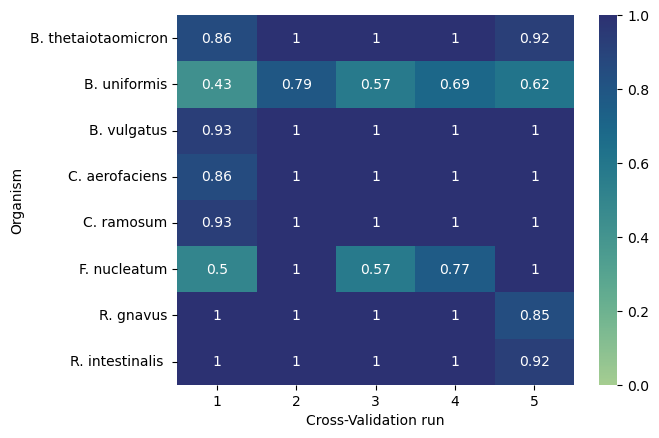

In [46]:
# Accuracy CV matrix
ax = sns.heatmap(metrics_df.pivot(index="Organism", columns="Cross-Validation run", values="Accuracy"),
                 vmin=0, vmax=1.0, annot=True, cmap=sns.color_palette("crest", as_cmap=True))
plt.savefig(f'../../runs/ML/annot/{algorithm}/heatmap_accuracies_1.png')  

In [47]:
plot_cv_confmat(ys=ys, target_labels=metrics_df.pivot(index="Organism", columns="Cross-Validation run", values="Accuracy").index,
                accuracies=np.mean(metrics_df.pivot(index="Organism", columns="Cross-Validation run", values="Accuracy").values, axis=1),
                confusion_matrices=np.sum(metrics_df.pivot(index="Organism", columns="Cross-Validation run", values="Conf_Mat").values, axis=1),
				outdir=f"../../runs/ML/annot/{algorithm}", name="class_annot_test_smac")

### DT depiction

In [ ]:
model = DecisionTreeClassifier(random_state=42)

# for i, estimator in enumerate(model.estimators_):
for i, s in enumerate(strains):
    model.fit(X.transpose(),ys.transpose()[i])
    plot_decision_trees(model=model, feature_names=X.index, class_names=["absent", s], outdir=outdir, name=f"decisiontree/tree_{s}{suffix}")

NameError: name 'DecisionTreeClassifier' is not defined

### Feature importance

In [61]:
feature_importances = {}
for i, s in enumerate(strains["0"]):
    model = XGBClassifier(**best_hp)
    model.fit(X.values, ys[f"{i}"])
    feature_importances[s] = model.feature_importances_

    imp_feat = feature_importances.get(s) > 0.1

    plt.bar(X.columns[imp_feat], feature_importances.get(s)[imp_feat])
    plt.savefig(f"../../reports/ML/XGBoost/important_features_{s}_3_strict.png")
    plt.close()

In [55]:
feat_imp_df = pd.DataFrame(feature_importances, index=X.columns)
feat_imp_df.to_csv("../../reports/ML/XGBoost/feature_importance_2.tsv", sep="\t")

In [60]:
feat_imp_df["B. vulgatus"].loc[feat_imp_df["B. vulgatus"].max() == feat_imp_df["B. vulgatus"]]

metNames
Palmitoylethanolamide[M+H]+\n3-Dehydrosphinganine[M+H]+\nSphingosine[M+H]    0.719717
Name: B. vulgatus, dtype: float32

In [62]:
strains

,0
0,C. ramosum
1,R. gnavus
2,C. aerofaciens
3,B. thetaiotaomicron
4,B. uniformis
5,B. vulgatus
6,F. nucleatum
7,R. intestinalis
